# Water Park Simulation 

## Yahlly Schein



##### imports

In [184]:
import numpy as np 
import heapq as hq  
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from math import floor

##### Define the objects

In [185]:
class Event():
    def __init__(self, time, event_type, group=None):
        self.time = time # event time
        self.event_type = event_type # type of the event
        self.group = group
        hq.heappush(event_log, self) #add the event to the events list

    def __lt__(self,event2):
        return self.time < event2.time
  
class Customer():
    def __init__(self, time):
        self.height = np.random.normal(160,10) #sample the height
        self.time = time
        
    def __lt__(self,customer2):
        return self.time < customer2.time
    
class Group():
    def __init__(self, time): 
        self.time = time
        self.num_rounds = 0 
        # sample the num od costumers in the group
        x = np.random.random(1)
        if x <= 0.35: # 1 customer in the group
            self.num_customers = 1
        elif  0.35 < x <=0.7: # 2 customers in the group
            self.num_customers = 2
        else: # 3 customers in the group
            self.num_customers = 3


#### define the get service func

In [186]:
def customer_gets_service(new_customer, curr_time):
    if new_customer.height < 140:
        Event(curr_time, "service_end")
    # can go
    elif new_customer.height > 150:
        glisha_time = np.random.uniform(1.5,2)
        Event(curr_time + glisha_time, "service_end") 
    # maybe can go - depends if in the 40%
    elif 150 > new_customer.height > 140:
        x2 = np.random.random(1)
        if x2 <= 0.4: # customer can go slide
            glisha_time = np.random.uniform(1.5,2)
            Event(curr_time + glisha_time, "service_end") 
        else:
            # customer can't go slide - talk for a minute
            Event(curr_time + 1, "talk_end") 

## Start simulation run

In [187]:
num_days = 100
Tmax = 60*10 # 10 hours * 60 minutes = 600

Time_bye = [0]*10
Num_in_wait = [0]*10

# run 100 iterations 
for i in range(num_days):
    
# This block represents 1 day
    # Setup and start the simulation
    curr_time = 0 # simulation clock 
    prev_time = 0 
    event_log = [] #eventlog
    Q = [] #the que
    Ls = 0 # num people in Sivuv
    A = 0 # how many sharatim busy
    B = 0 # did the break happened? (0 = No , 1 = Yes)

    #create first event
    t = np.random.exponential(1.5)
    Event(t, "group_arrival")
    Event(240, "check_if_break")
    event = hq.heappop(event_log)
    curr_time = event.time

    while curr_time < Tmax:
        if event.event_type == "group_arrival":
            new_group = Group(event.time)
            if len(Q) > 5:
                    #this group will be back in 5 minutes
                    new_group.num_rounds = 1
                    Ls += new_group.num_customers
                    Event(curr_time + 5 ,"group_back", new_group) # one more round for this group
            else: 
                for i in range(new_group.num_customers):
                    Event(curr_time, "one_arrival") #create num_customers "personal" arrivals


            # always create the next group arrival
            sample = None
            if curr_time <= 240:
                sample = np.random.exponential(1.5)
            elif 360 >= curr_time > 240:
                sample = np.random.exponential(4)
            else:
                sample = np.random.exponential(2)
            # create the next group arrival depending on the time
            Event(curr_time + sample, "group_arrival")

            
        elif event.event_type == "group_back":
            if len(Q) > 5:
                if event.group.num_rounds == 1:
                    event.group.num_rounds = 2
                    Event(curr_time + 5 ,"group_back", event.group) # one more round for this group
                else: # event.group.num_rounds == 2:
                ## they leave
                    Ls -= event.group.num_customers
                    # these customers left the Q because of it's length:
                    hour_in_the_day = floor(curr_time/60)
                    Time_bye[hour_in_the_day] += event.group.num_customers
            else:
                new_group = event.group
                Ls -= new_group.num_customers
                for i in range(new_group.num_customers):
                    Event(curr_time, "one_arrival")   #create num_customers "personal" arrivals


        elif event.event_type == "one_arrival": 
            new_customer = Customer(event.time)
            if A<2:
                A += 1
                customer_gets_service(new_customer, curr_time) ## if we have a free Maglesha - give the client service
            else: # A = 2 
                hq.heappush(Q,new_customer) ## if not - send him to the que 


        elif event.event_type == "service_end":
            # is it time for the break?
            if B == 0 and curr_time > 240: #conditions for the break
                B = 1
                break1 = np.random.normal(20, 2)
                break2 = np.random.normal(20, 2)
                Event(break1 + break2 + curr_time, "break_end")
            else: 
                #queue is empty
                if len(Q) == 0:
                    A -= 1
                #queue is not empty
                else:
                    new_customer = hq.heappop(Q)
                    customer_gets_service(new_customer, curr_time)


        elif event.event_type == "talk_end": 
            # is it time for the break?
            if B == 0 and curr_time > 240:
                B = 1
                break1 = np.random.normal(20, 2)
                break2 = np.random.normal(20, 2)
                Event(break1 + break2 + curr_time, "break_end")
            else: 
                #queue is empty
                if len(Q) == 0:
                    A -= 1
                #queue is not empty
                else:
                    new_customer = hq.heappop(Q)
                    customer_gets_service(new_customer, curr_time)
        
        
        #when it's 12 the event checks if it is possible to take the break now
        elif event.event_type == "check_if_break":
            #if the break hasen't happened yet
            if B == 0 and A<2:
                B = 1
                A += 1 
                break1 = np.random.normal(20, 2)
                break2 = np.random.normal(20, 2)
                Event(break1 + break2 + curr_time, "break_end")
            #if the operator is already in the break
            else:
                None


        elif event.event_type == "break_end":
            #queue is empty
            if len(Q) == 0:
                A -= 1
            #queue is not empty, return to service
            else:
                new_customer = hq.heappop(Q)
                customer_gets_service(new_customer, curr_time)


        event = hq.heappop(event_log)
        prev_time = curr_time
        curr_time = event.time
        ## calculations for the waiting time 
        if floor(curr_time/60) == 10:
            #Num_in_wait after 18:00  is not interesting - calculate what happened before 18
            Num_in_wait[9] += (len(Q) + Ls) * (10 - prev_time/60)
        #if the events are in the same hour - add to this hour
        elif floor(curr_time/60) == floor(prev_time/60):
            Num_in_wait[floor(curr_time/60)] += (len(Q) + Ls) * ((curr_time - prev_time)/60)
        #if the events are not in the same hour - add to the different hours 
        else:
            Num_in_wait[floor(curr_time/60)] += (len(Q) + Ls) * ((curr_time%60)/60)
            Num_in_wait[floor(prev_time/60)] += (len(Q) + Ls) * (curr_time//60 - prev_time/60)

# Plots

In [188]:
E_in_wait = [0]*10
Average_leavers = [0]*10

for i in range(10):
    E_in_wait[i] = round(Num_in_wait[i]/num_days, 4)
    Average_leavers[i] = Time_bye[i]/num_days

Hours = ["08:00-09:00", "09:00-10:00", "10:00-11:00", "11:00-12:00", "12:00-13:00", "13:00-14:00", "14:00-15:00",
     "15:00-16:00", "16:00-17:00", "17:00-18:00"]


##### First graph - E of waiting customers per hour

In [189]:
E_in_wait 

[5.3503, 7.6072, 7.658, 7.7055, 3.8383, 0.458, 2.4376, 2.6095, 3.2505, 3.2378]

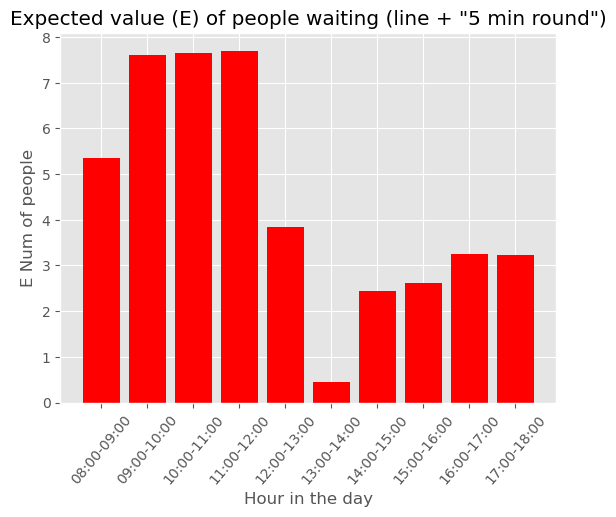

In [190]:
plt.bar(Hours, E_in_wait, color='red')
plt.title('Expected value (E) of people waiting (line + "5 min round")')
plt.xticks(Hours, rotation=50)
plt.xlabel('Hour in the day')
plt.ylabel('E Num of people')
plt.show()

##### Second graph - Num leavers beacuse of Q length per hour

In [191]:
Average_leavers

[3.86, 8.51, 8.85, 7.93, 3.06, 0.0, 0.8, 0.87, 1.1, 1.1]

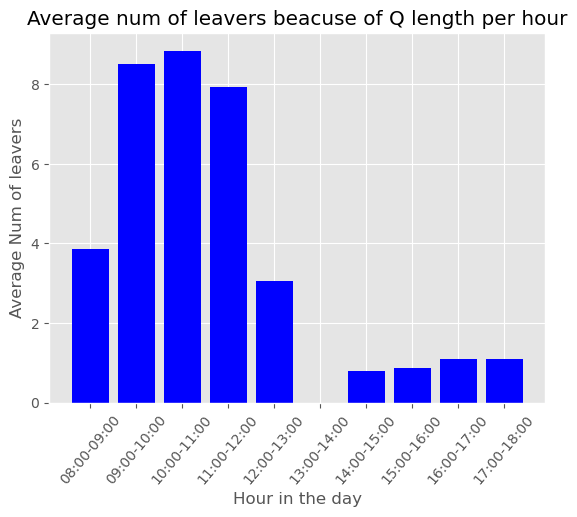

In [192]:
plt.bar(Hours, Average_leavers, color='blue')
plt.title('Average num of leavers beacuse of Q length per hour')
plt.xticks(Hours, rotation=50)
plt.xlabel('Hour in the day')
plt.ylabel('Average Num of leavers')
plt.show()